<div align="center">

# **Cálculo de Tasas Puras**

**Tasa Pura = Frecuencia × Severidad Esperada**

</div>

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("husl")

# Crear directorio para imágenes si no existe
os.makedirs('../report/images', exist_ok=True)
os.makedirs('../data/out', exist_ok=True)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 1. Parámetros de los Modelos

### Modelo de Frecuencia (GLM Binomial - Link Logit)

$$P(Y=1) = \text{logit}^{-1}(\eta) = \frac{1}{1+e^{-\eta}}$$

donde:
$$\eta = \beta_0 + \beta_{OTROS} \cdot I(OTROS) + \beta_{REGIONES} \cdot I(REGIONES) + \beta_{PERIODO} \cdot PERIODO$$

### Modelo de Severidad (Beta-Bernoulli)

$$E[X] = \pi + (1-\pi) \cdot \frac{\alpha}{\alpha + \beta}$$

In [3]:
# ══════════════════════════════════════════════════════════════════════════════
#                      PARÁMETROS DE LOS MODELOS
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("PARÁMETROS DE LOS MODELOS")
print("=" * 80)

# Coeficientes del GLM Bernoulli (de data/tmp/glm_coeficientes_frecuencia.csv)
# Categoría de referencia: BOGOTA
coef_glm = {
    'CALIDAD DE LA OBRA': {
        'Intercept': -7.102, 
        'OTROS': -0.5423, 
        'REGIONES': -0.6689, 
        'PERIODO': 0.4735
    },
    'CUMPLIMIENTO': {
        'Intercept': -4.1402, 
        'OTROS': 0.4795, 
        'REGIONES': 0.0963, 
        'PERIODO': 0.4243
    },
    'PRESTACIONES SOCIALES': {
        'Intercept': -6.1118, 
        'OTROS': 1.0027, 
        'REGIONES': -0.8716, 
        'PERIODO': 0.3594
    }
}

# Parámetros del modelo Beta-Bernoulli de severidad (de modelacion_severidad.ipynb)
params_severidad = {
    'CALIDAD DE LA OBRA': {'pi': 0.162679, 'alpha': 0.270191, 'beta': 0.516767},
    'CUMPLIMIENTO': {'pi': 0.124478, 'alpha': 0.388464, 'beta': 1.056647},
    'PRESTACIONES SOCIALES': {'pi': 0.055556, 'alpha': 0.348781, 'beta': 1.056302}
}

print("\n1. COEFICIENTES GLM FRECUENCIA (Link Logit)")
print("-" * 80)
print(f"{'Cobertura':<25} {'Intercept':>10} {'OTROS':>10} {'REGIONES':>10} {'PERIODO':>10}")
print("-" * 80)
for cob, coef in coef_glm.items():
    print(f"{cob:<25} {coef['Intercept']:>10.4f} {coef['OTROS']:>10.4f} {coef['REGIONES']:>10.4f} {coef['PERIODO']:>10.4f}")

print("\n2. PARÁMETROS SEVERIDAD (Beta-Bernoulli)")
print("-" * 80)
print(f"{'Cobertura':<25} {'π':>10} {'α':>10} {'β':>10}")
print("-" * 80)
for cob, params in params_severidad.items():
    print(f"{cob:<25} {params['pi']:>10.6f} {params['alpha']:>10.6f} {params['beta']:>10.6f}")

PARÁMETROS DE LOS MODELOS

1. COEFICIENTES GLM FRECUENCIA (Link Logit)
--------------------------------------------------------------------------------
Cobertura                  Intercept      OTROS   REGIONES    PERIODO
--------------------------------------------------------------------------------
CALIDAD DE LA OBRA           -7.1020    -0.5423    -0.6689     0.4735
CUMPLIMIENTO                 -4.1402     0.4795     0.0963     0.4243
PRESTACIONES SOCIALES        -6.1118     1.0027    -0.8716     0.3594

2. PARÁMETROS SEVERIDAD (Beta-Bernoulli)
--------------------------------------------------------------------------------
Cobertura                          π          α          β
--------------------------------------------------------------------------------
CALIDAD DE LA OBRA          0.162679   0.270191   0.516767
CUMPLIMIENTO                0.124478   0.388464   1.056647
PRESTACIONES SOCIALES       0.055556   0.348781   1.056302


## 2. Funciones de Cálculo

In [4]:
# ══════════════════════════════════════════════════════════════════════════════
#                      FUNCIONES DE CÁLCULO
# ══════════════════════════════════════════════════════════════════════════════

def calc_frecuencia(coef, periodo, departamento):
    """
    Calcula la frecuencia predicha usando el GLM Binomial con link logit.
    
    P(Y=1) = 1 / (1 + exp(-η))
    η = Intercept + β_OTROS×I(OTROS) + β_REGIONES×I(REGIONES) + β_PERIODO×PERIODO
    
    Parámetros:
    -----------
    coef : dict - Coeficientes del modelo {Intercept, OTROS, REGIONES, PERIODO}
    periodo : int - Período de vigencia (1, 2, ..., 10)
    departamento : str - Cluster de departamento ('BOGOTA', 'REGIONES', 'OTROS')
    
    Retorna:
    --------
    float - Probabilidad de siniestro (frecuencia)
    """
    # Calcular predictor lineal η
    eta = coef['Intercept'] + coef['PERIODO'] * periodo
    
    # Agregar efecto del departamento (BOGOTA es la categoría de referencia)
    if departamento == 'OTROS':
        eta += coef['OTROS']
    elif departamento == 'REGIONES':
        eta += coef['REGIONES']
    # Si es BOGOTA, no se agrega nada (coeficiente = 0)
    
    # Aplicar función de enlace inversa (logit⁻¹)
    prob = 1 / (1 + np.exp(-eta))
    
    return prob


def calc_severidad_esperada(params):
    """
    Calcula la severidad esperada del modelo Beta-Bernoulli.
    
    E[X] = π + (1-π) × α/(α+β)
    
    Parámetros:
    -----------
    params : dict - Parámetros {pi, alpha, beta}
    
    Retorna:
    --------
    float - Severidad esperada (proporción de pago esperada)
    """
    pi = params['pi']
    alpha = params['alpha']
    beta = params['beta']
    
    e_beta = alpha / (alpha + beta)  # E[Beta(α,β)]
    e_severidad = pi + (1 - pi) * e_beta  # E[Mixtura]
    
    return e_severidad


# Calcular severidades esperadas para cada cobertura
print("=" * 80)
print("SEVERIDADES ESPERADAS POR COBERTURA")
print("=" * 80)

severidades_esperadas = {}
print(f"\n{'Cobertura':<25} {'E[Severidad]':>15}")
print("-" * 45)
for cob, params in params_severidad.items():
    e_sev = calc_severidad_esperada(params)
    severidades_esperadas[cob] = e_sev
    print(f"{cob:<25} {e_sev:>15.6f}")

print("\n" + "=" * 80)

SEVERIDADES ESPERADAS POR COBERTURA

Cobertura                    E[Severidad]
---------------------------------------------
CALIDAD DE LA OBRA               0.450161
CUMPLIMIENTO                     0.359829
PRESTACIONES SOCIALES            0.289993



## 3. Generación de Tabla de Tasas Puras

In [5]:
# ══════════════════════════════════════════════════════════════════════════════
#                      GENERAR TABLA DE TASAS PURAS
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("GENERACIÓN DE TABLA DE TASAS PURAS")
print("=" * 80)

# Definir combinaciones
coberturas = ['CALIDAD DE LA OBRA', 'CUMPLIMIENTO', 'PRESTACIONES SOCIALES']
periodos = list(range(0, 11))  # 0 a 10
departamentos = ['BOGOTA', 'REGIONES', 'OTROS']

print(f"\nCoberturas: {coberturas}")
print(f"Periodos: {periodos}")
print(f"Departamentos: {departamentos}")
print(f"\nTotal combinaciones: {len(coberturas) * len(periodos) * len(departamentos)}")

# Generar todas las combinaciones
resultados = []

for cobertura in coberturas:
    coef = coef_glm[cobertura]
    e_sev = severidades_esperadas[cobertura]
    
    for periodo in periodos:
        for depto in departamentos:
            # Calcular frecuencia
            frecuencia = calc_frecuencia(coef, periodo, depto)
            
            # Calcular tasa pura = frecuencia × severidad esperada
            tasa_pura = frecuencia * e_sev
            
            resultados.append({
                'COBERTURA': cobertura,
                'PERIODO': periodo,
                'DEPARTAMENTO': depto,
                'FRECUENCIA': frecuencia,
                'SEVERIDAD_ESPERADA': e_sev,
                'TASA_PURA': tasa_pura
            })

# Crear DataFrame
df_tasas = pd.DataFrame(resultados)

print("\n" + "=" * 80)
print("TABLA DE TASAS PURAS GENERADA")
print("=" * 80)
print(f"\nDimensiones: {df_tasas.shape}")
print(df_tasas.head(15))

GENERACIÓN DE TABLA DE TASAS PURAS

Coberturas: ['CALIDAD DE LA OBRA', 'CUMPLIMIENTO', 'PRESTACIONES SOCIALES']
Periodos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Departamentos: ['BOGOTA', 'REGIONES', 'OTROS']

Total combinaciones: 99

TABLA DE TASAS PURAS GENERADA

Dimensiones: (99, 6)
             COBERTURA  PERIODO DEPARTAMENTO  FRECUENCIA  SEVERIDAD_ESPERADA  \
0   CALIDAD DE LA OBRA        0       BOGOTA    0.000823            0.450161   
1   CALIDAD DE LA OBRA        0     REGIONES    0.000422            0.450161   
2   CALIDAD DE LA OBRA        0        OTROS    0.000479            0.450161   
3   CALIDAD DE LA OBRA        1       BOGOTA    0.001320            0.450161   
4   CALIDAD DE LA OBRA        1     REGIONES    0.000677            0.450161   
5   CALIDAD DE LA OBRA        1        OTROS    0.000768            0.450161   
6   CALIDAD DE LA OBRA        2       BOGOTA    0.002118            0.450161   
7   CALIDAD DE LA OBRA        2     REGIONES    0.001086            0.450161  

In [6]:
# ══════════════════════════════════════════════════════════════════════════════
#                      TABLA PIVOTEADA POR COBERTURA
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("TASAS PURAS (f × s) POR COBERTURA, PERIODO Y DEPARTAMENTO")
print("=" * 80)

# Crear tablas pivoteadas para cada cobertura
tablas_pivoteadas = {}

for cobertura in coberturas:
    df_cob = df_tasas[df_tasas['COBERTURA'] == cobertura].copy()
    
    # Pivotear: filas = PERIODO, columnas = DEPARTAMENTO
    pivot = df_cob.pivot(
        index='PERIODO', 
        columns='DEPARTAMENTO', 
        values='TASA_PURA'
    )
    
    # Ordenar columnas
    pivot = pivot[['BOGOTA', 'REGIONES', 'OTROS']]
    
    tablas_pivoteadas[cobertura] = pivot
    
    print(f"\n>>> {cobertura}")
    print(f"    Severidad esperada: {severidades_esperadas[cobertura]:.6f}")
    print("-" * 50)
    print((pivot * 100).round(4).to_string())  # Mostrar en porcentaje
    print()

print("\nNota: Valores mostrados en porcentaje (×100)")

TASAS PURAS (f × s) POR COBERTURA, PERIODO Y DEPARTAMENTO

>>> CALIDAD DE LA OBRA
    Severidad esperada: 0.450161
--------------------------------------------------
DEPARTAMENTO  BOGOTA  REGIONES   OTROS
PERIODO                               
0             0.0370    0.0190  0.0215
1             0.0594    0.0305  0.0346
2             0.0954    0.0489  0.0555
3             0.1529    0.0785  0.0890
4             0.2450    0.1258  0.1428
5             0.3921    0.2017  0.2288
6             0.6263    0.3230  0.3662
7             0.9971    0.5164  0.5852
8             1.5798    0.8234  0.9322
9             2.4837    1.3075  1.4782
10            3.8590    2.0631  2.3271


>>> CUMPLIMIENTO
    Severidad esperada: 0.359829
--------------------------------------------------
DEPARTAMENTO   BOGOTA  REGIONES    OTROS
PERIODO                                 
0              0.5639    0.6199   0.9021
1              0.8548    0.9389   1.3608
2              1.2904    1.4157   2.0393
3              1.93

## 4. Visualización con Seaborn

GENERANDO VISUALIZACIÓN DE TASAS PURAS



✓ Imagen guardada: ../report/images/heatmap_tasas_puras.png


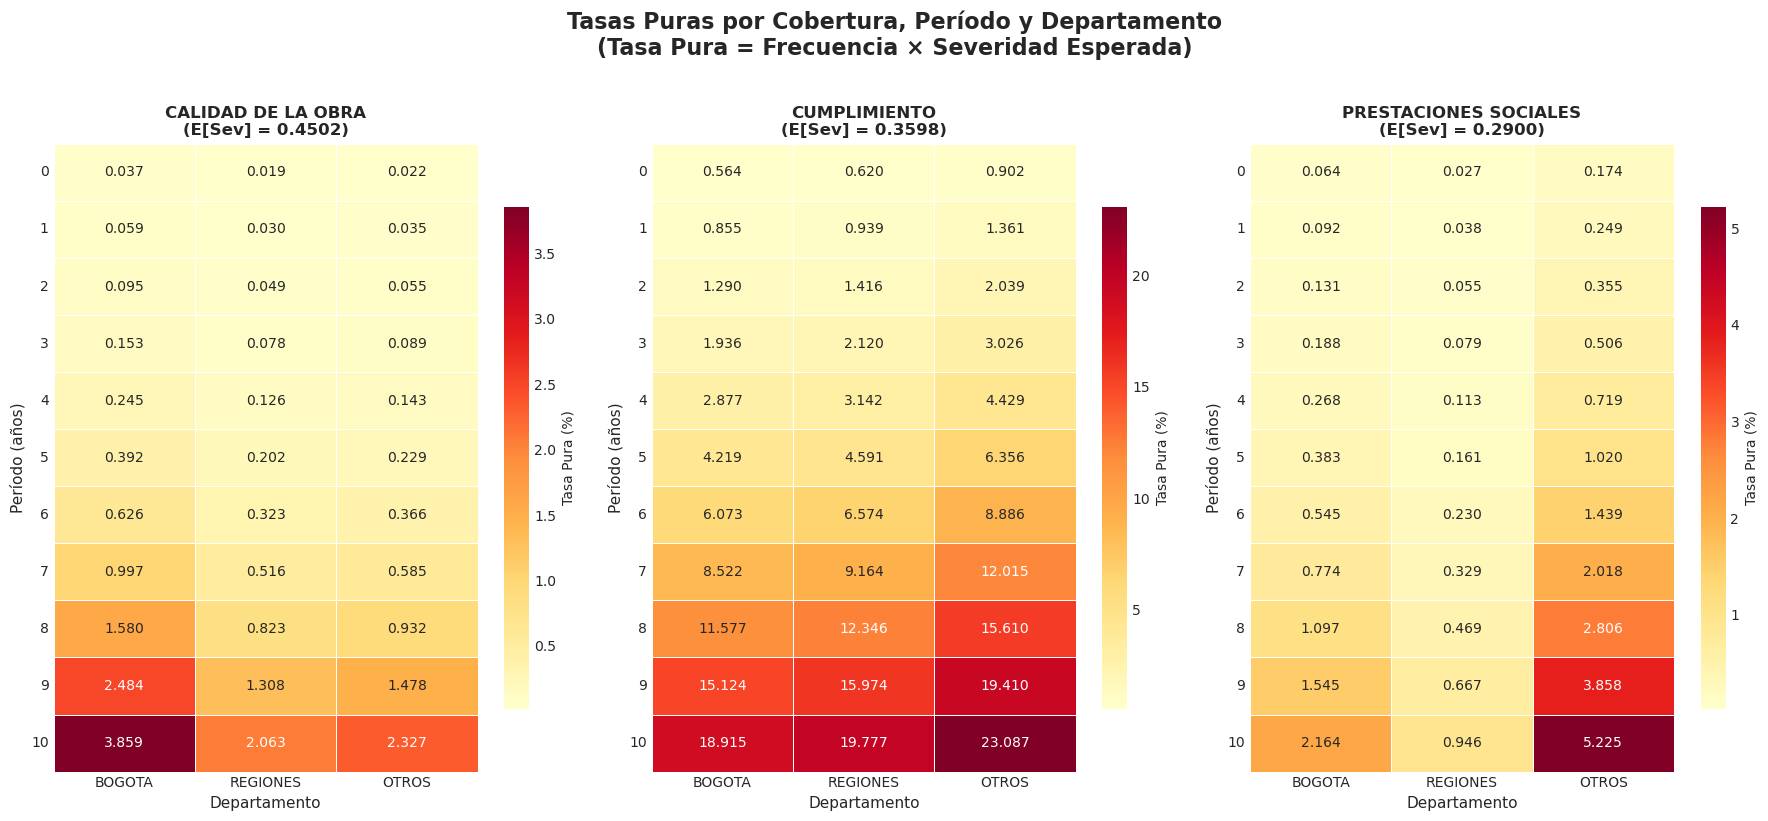

In [7]:
# ══════════════════════════════════════════════════════════════════════════════
#                      VISUALIZACIÓN CON SEABORN - HEATMAPS
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("GENERANDO VISUALIZACIÓN DE TASAS PURAS")
print("=" * 80)

# Crear figura con 3 subplots (uno por cobertura)
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Tasas Puras por Cobertura, Período y Departamento\n(Tasa Pura = Frecuencia × Severidad Esperada)', 
             fontsize=16, fontweight='bold', y=1.02)

# Paleta de colores
cmap = 'YlOrRd'

for idx, cobertura in enumerate(coberturas):
    ax = axes[idx]
    
    # Obtener tabla pivoteada (en porcentaje)
    data = tablas_pivoteadas[cobertura] * 100
    
    # Crear heatmap
    sns.heatmap(
        data,
        ax=ax,
        annot=True,
        fmt='.3f',
        cmap=cmap,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Tasa Pura (%)', 'shrink': 0.8}
    )
    
    # Formatear
    ax.set_title(f'{cobertura}\n(E[Sev] = {severidades_esperadas[cobertura]:.4f})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Departamento', fontsize=11)
    ax.set_ylabel('Período (años)', fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()

# Guardar imagen
plt.savefig('../report/images/heatmap_tasas_puras.png', dpi=300, bbox_inches='tight')
print("\n✓ Imagen guardada: ../report/images/heatmap_tasas_puras.png")

plt.show()

✓ Imagen guardada: ../report/images/lineas_tasas_puras.png


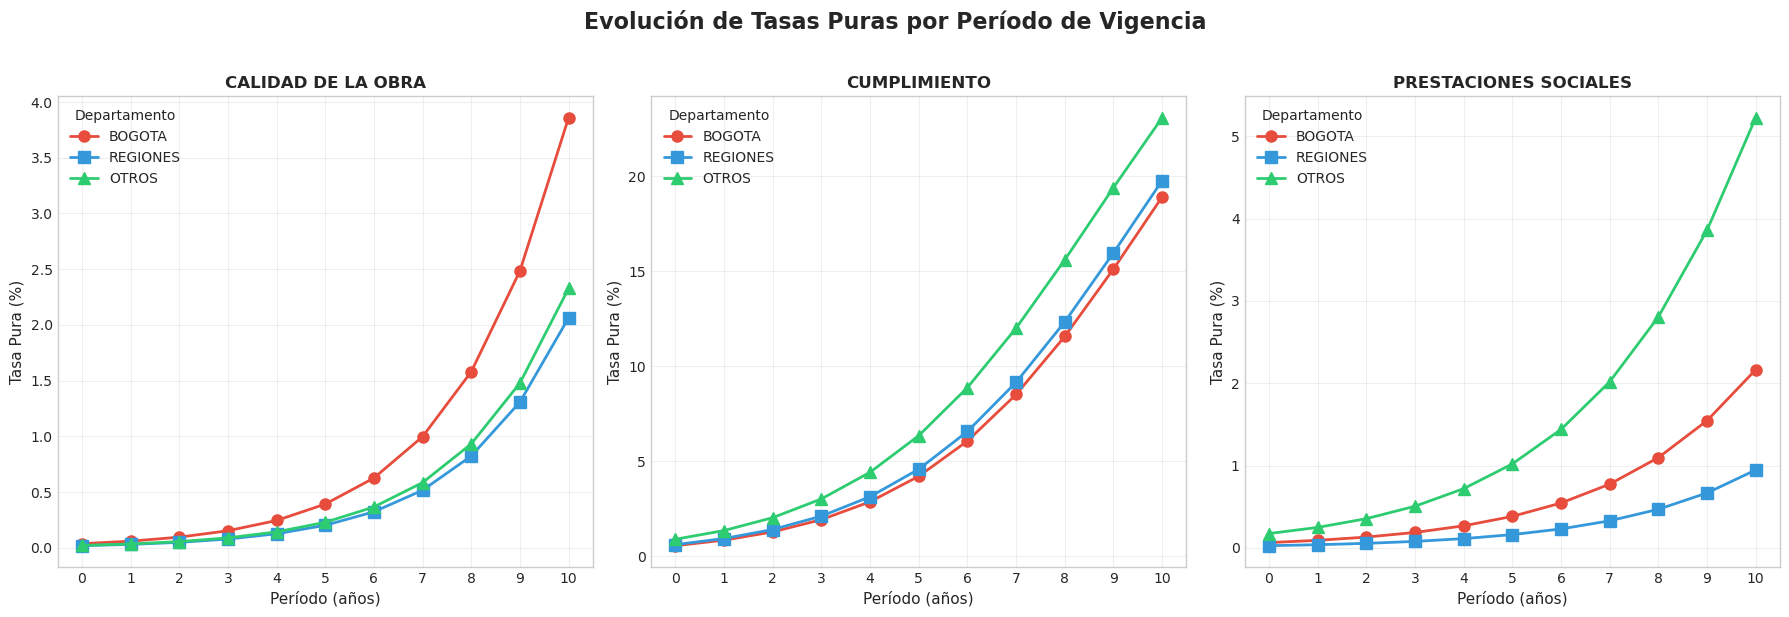

In [8]:
# ══════════════════════════════════════════════════════════════════════════════
#                      GRÁFICO DE LÍNEAS POR PERÍODO
# ══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Evolución de Tasas Puras por Período de Vigencia', 
             fontsize=16, fontweight='bold', y=1.02)

colores_depto = {'BOGOTA': '#E74C3C', 'REGIONES': '#3498DB', 'OTROS': '#2ECC71'}
marcadores = {'BOGOTA': 'o', 'REGIONES': 's', 'OTROS': '^'}

for idx, cobertura in enumerate(coberturas):
    ax = axes[idx]
    
    df_cob = df_tasas[df_tasas['COBERTURA'] == cobertura]
    
    for depto in departamentos:
        df_depto = df_cob[df_cob['DEPARTAMENTO'] == depto]
        ax.plot(
            df_depto['PERIODO'], 
            df_depto['TASA_PURA'] * 100,  # En porcentaje
            marker=marcadores[depto],
            color=colores_depto[depto],
            linewidth=2,
            markersize=8,
            label=depto
        )
    
    ax.set_title(f'{cobertura}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Período (años)', fontsize=11)
    ax.set_ylabel('Tasa Pura (%)', fontsize=11)
    ax.legend(title='Departamento', loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(periodos)

plt.tight_layout()

# Guardar imagen
plt.savefig('../report/images/lineas_tasas_puras.png', dpi=300, bbox_inches='tight')
print("✓ Imagen guardada: ../report/images/lineas_tasas_puras.png")

plt.show()

## 5. Exportación a Excel

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
#                      EXPORTAR A EXCEL
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("EXPORTANDO A EXCEL")
print("=" * 80)

# Crear archivo Excel con múltiples hojas
ruta_excel = '../data/out/tasas_puras.xlsx'

with pd.ExcelWriter(ruta_excel, engine='openpyxl') as writer:
    
    # Hoja 1: Tabla completa
    df_export = df_tasas.copy()
    df_export['FRECUENCIA_%'] = df_export['FRECUENCIA'] * 100
    df_export['TASA_PURA_%'] = df_export['TASA_PURA'] * 100
    df_export.to_excel(writer, sheet_name='Datos_Completos', index=False)
    print("\n✓ Hoja 'Datos_Completos' creada")
    
    # Hoja 2: Resumen por cobertura (tabla pivoteada de tasas puras)
    # Crear una tabla consolidada
    lista_consolidada = []
    for cobertura in coberturas:
        pivot = tablas_pivoteadas[cobertura] * 100  # En porcentaje
        pivot = pivot.reset_index()
        pivot['COBERTURA'] = cobertura
        pivot['SEVERIDAD_ESP'] = severidades_esperadas[cobertura]
        lista_consolidada.append(pivot)
    
    df_consolidado = pd.concat(lista_consolidada, ignore_index=True)
    df_consolidado = df_consolidado[['COBERTURA', 'SEVERIDAD_ESP', 'PERIODO', 'BOGOTA', 'REGIONES', 'OTROS']]
    df_consolidado.to_excel(writer, sheet_name='Tasas_Puras_Resumen', index=False)
    print("✓ Hoja 'Tasas_Puras_Resumen' creada")
    
    # Hojas individuales por cobertura
    for cobertura in coberturas:
        nombre_hoja = cobertura.replace(' ', '_')[:31]  # Máximo 31 caracteres
        pivot = tablas_pivoteadas[cobertura] * 100
        pivot.to_excel(writer, sheet_name=nombre_hoja)
        print(f"✓ Hoja '{nombre_hoja}' creada")
    
    # Hoja de parámetros
    params_df = pd.DataFrame([
        {'Cobertura': cob, 'π': p['pi'], 'α': p['alpha'], 'β': p['beta'], 
         'E[Severidad]': severidades_esperadas[cob]}
        for cob, p in params_severidad.items()
    ])
    params_df.to_excel(writer, sheet_name='Parametros_Severidad', index=False)
    print("✓ Hoja 'Parametros_Severidad' creada")
    
    # Hoja de coeficientes GLM
    coef_df = pd.DataFrame([
        {'Cobertura': cob, 'Intercept': c['Intercept'], 'OTROS': c['OTROS'], 
         'REGIONES': c['REGIONES'], 'PERIODO': c['PERIODO']}
        for cob, c in coef_glm.items()
    ])
    coef_df.to_excel(writer, sheet_name='Coeficientes_GLM', index=False)
    print("✓ Hoja 'Coeficientes_GLM' creada")

print(f"\n" + "=" * 80)
print(f"✓ ARCHIVO EXCEL GUARDADO: {ruta_excel}")
print("=" * 80)

EXPORTANDO A EXCEL

✓ Hoja 'Datos_Completos' creada
✓ Hoja 'Tasas_Puras_Resumen' creada
✓ Hoja 'CALIDAD_DE_LA_OBRA' creada
✓ Hoja 'CUMPLIMIENTO' creada
✓ Hoja 'PRESTACIONES_SOCIALES' creada
✓ Hoja 'Parametros_Severidad' creada
✓ Hoja 'Coeficientes_GLM' creada

✓ ARCHIVO EXCEL GUARDADO: ../data/out/tasas_puras.xlsx


In [10]:
# ══════════════════════════════════════════════════════════════════════════════
#                      FORMATEO DEL EXCEL
# ══════════════════════════════════════════════════════════════════════════════

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows

print("=" * 80)
print("APLICANDO FORMATO AL EXCEL")
print("=" * 80)

# Cargar el archivo
wb = load_workbook(ruta_excel)

# Estilos
header_font = Font(bold=True, color='FFFFFF')
header_fill = PatternFill(start_color='2E86AB', end_color='2E86AB', fill_type='solid')
border = Border(
    left=Side(style='thin'),
    right=Side(style='thin'),
    top=Side(style='thin'),
    bottom=Side(style='thin')
)
center_alignment = Alignment(horizontal='center', vertical='center')

# Aplicar formato a cada hoja
for sheet_name in wb.sheetnames:
    ws = wb[sheet_name]
    
    # Formato de encabezados (primera fila)
    for cell in ws[1]:
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = center_alignment
        cell.border = border
    
    # Formato de datos
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = center_alignment
            cell.border = border
            # Formato numérico para decimales
            if isinstance(cell.value, float):
                cell.number_format = '0.0000'
    
    # Ajustar ancho de columnas
    for column in ws.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = min(max_length + 2, 25)
        ws.column_dimensions[column_letter].width = adjusted_width
    
    print(f"✓ Formato aplicado a hoja '{sheet_name}'")

# Guardar
wb.save(ruta_excel)

print(f"\n" + "=" * 80)
print(f"✓ EXCEL FORMATEADO Y GUARDADO: {ruta_excel}")
print("=" * 80)

APLICANDO FORMATO AL EXCEL
✓ Formato aplicado a hoja 'Datos_Completos'
✓ Formato aplicado a hoja 'Tasas_Puras_Resumen'
✓ Formato aplicado a hoja 'CALIDAD_DE_LA_OBRA'
✓ Formato aplicado a hoja 'CUMPLIMIENTO'
✓ Formato aplicado a hoja 'PRESTACIONES_SOCIALES'
✓ Formato aplicado a hoja 'Parametros_Severidad'
✓ Formato aplicado a hoja 'Coeficientes_GLM'

✓ EXCEL FORMATEADO Y GUARDADO: ../data/out/tasas_puras.xlsx


## 6. Resumen Final

In [11]:
# ══════════════════════════════════════════════════════════════════════════════
#                      RESUMEN FINAL
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("RESUMEN FINAL - TASAS PURAS POR COBERTURA")
print("=" * 80)

print("\nFórmula: Tasa Pura = Frecuencia(PERIODO, DEPARTAMENTO) × E[Severidad]")
print("")

# Resumen de estadísticas
resumen = df_tasas.groupby('COBERTURA').agg({
    'FRECUENCIA': ['min', 'max', 'mean'],
    'SEVERIDAD_ESPERADA': 'first',
    'TASA_PURA': ['min', 'max', 'mean']
}).round(6)

resumen.columns = ['Freq_Min', 'Freq_Max', 'Freq_Media', 'E[Sev]', 
                   'Tasa_Min', 'Tasa_Max', 'Tasa_Media']

print("\nESTADÍSTICAS POR COBERTURA:")
print("-" * 100)
print(resumen.to_string())

print("\n" + "=" * 80)
print("ARCHIVOS GENERADOS:")
print("=" * 80)
print("  1. ../data/out/tasas_puras.xlsx")
print("  2. ../report/images/heatmap_tasas_puras.png")
print("  3. ../report/images/lineas_tasas_puras.png")
print("\n✓ Proceso completado exitosamente")

RESUMEN FINAL - TASAS PURAS POR COBERTURA

Fórmula: Tasa Pura = Frecuencia(PERIODO, DEPARTAMENTO) × E[Severidad]


ESTADÍSTICAS POR COBERTURA:
----------------------------------------------------------------------------------------------------
                       Freq_Min  Freq_Max  Freq_Media    E[Sev]  Tasa_Min  Tasa_Max  Tasa_Media
COBERTURA                                                                                      
CALIDAD DE LA OBRA     0.000422  0.085724    0.015029  0.450161  0.000190  0.038590    0.006766
CUMPLIMIENTO           0.015670  0.641596    0.206947  0.359829  0.005639  0.230865    0.074466
PRESTACIONES SOCIALES  0.000926  0.180184    0.030025  0.289993  0.000269  0.052252    0.008707

ARCHIVOS GENERADOS:
  1. ../data/out/tasas_puras.xlsx
  2. ../report/images/heatmap_tasas_puras.png
  3. ../report/images/lineas_tasas_puras.png

✓ Proceso completado exitosamente
